# Capstone Project: Social media sentiment analysis 
## Part 4: Topic Modeling

In [143]:
# Import libraries
import requests
import json
import pandas as pd
import numpy as np
import time
import random
import re
import csv

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas.util.testing as tm
import spacy

# Gensim libraries
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.wrappers import LdaMallet
import pyLDAvis.gensim
from gensim.models import CoherenceModel, Word2Vec, LsiModel, KeyedVectors, fasttext,LdaModel
from gensim import matutils
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Enable logging for gensim - optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocess Twitter comments for topic modeling

In [144]:
# Call data from Part 2
tweet_combined_clean=pd.read_csv('./dataset/tweet_combined_clean_v1.csv')
samsung_tweet_neg=pd.read_csv('./dataset/samsung_tweet_neg.csv')
samsung_tweet_pos=pd.read_csv('./dataset/samsung_tweet_pos.csv')

In [145]:
# Unlike VADER, topic modeling requires extensive data cleaning - Edit stopwords to exclude emotional words like 'like','love' and brand names 'Samsung', 'Apple', 'Huawei'

lemm = WordNetLemmatizer()

def text_processer(text):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
        
    # 4. Remove stop words
    stop_words = set(stopwords.words("english"))
    stop_words.update(['samsung','huawei','apple','http','like','really','want','good','say','love','better','much',
                       'day','lol','well','need','could','take','twt','add','maxwinebach','nhlblackhawk','smtshepossa',
                       'niantichelp','recognised','view','great','doh','samsungmobile','okay','check','feel','always',
                       'yes','stop','even','every','already','u','something','go','see','sure','shit','said','https','com','www','hi','please','co','thanks','one',
                       'think','got','also', 'make','know','use', 'would','get','look','never','still','mtshepossa','akinjoshua',
                       'pay','using','time','b','c','d','e','f','g','h','i','ksvaljek', 'right', 'used','godissfroot','nhlblackhawks','http',
                       'j','k','l','n','m','o','p','q','r','s','t','u','v','w','x','y','z', 'sorry', 'part', 'u', 'let','as', 'saying', 'bit', 
                       'update', 'techquotesdaily','oh', 'yeah','frecowang', 'bts', 'pak','ok','fuck','come','thing','south','settle','level', 
                       'took','actually','stand','im','watch', 'jezdez','offby','dirtytesla','universeice','as', 'thank', 'thanks', 'seem', 'seems',
                        'way','put','made','thought', 'jack'])
    filtered_words=[w for w in words if not w in stop_words]

    # 5. Lemmatize words.
    lemmed_words = [lemm.lemmatize(i) for i in filtered_words]
    
    return (" ".join(lemmed_words))

In [146]:
# Initialise both types of vectorizer for comparison
cv = CountVectorizer(analyzer='word',       
                             min_df=10,
                            token_pattern='[a-zA-Z0-9]{3,}') #set number of characters to be more than 3 per word

tv = TfidfVectorizer(analyzer='word',       
                             min_df=10,
                            token_pattern='[a-zA-Z0-9]{3,}') #set number of characters to be more than 3 per word

## LDA Modeling

## Samsung topic modeling

In [147]:
tweet_samsung_clean=tweet_combined_clean[tweet_combined_clean['brand']==0]
tweet_samsung_words=tweet_samsung_clean['text'].apply(text_processer)

samsung_cv=cv.fit_transform(tweet_samsung_words)
samsung_tv=tv.fit_transform(tweet_samsung_words)

Mean number of words per tweet   :  48.0
Median number of words per tweet :  49.0


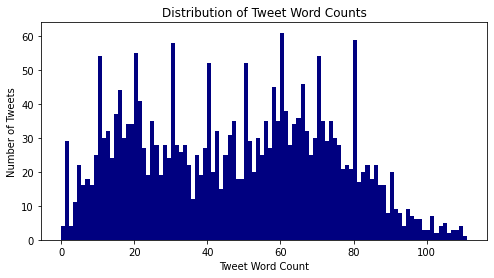

In [148]:
samsung_text_length=[len(d) for d in tweet_samsung_words];
# Plot
plt.figure(figsize=(8,4))
plt.hist(samsung_text_length, bins = 100, color='navy')
print("Mean number of words per tweet   : ", (round(np.mean(samsung_text_length))))
print("Median number of words per tweet : ", (round(np.median(samsung_text_length))))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

In [149]:
# LDA gridsearch with tfid vectorizer

# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_tv)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_tv))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -3338.778585698505
Model Perplexity:  235.81216268407195


In [150]:
# LDA gridsearch with countvectorizer

# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_cv)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_cv))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -5198.519598210621
Model Perplexity:  183.090851937965


Given the lower perlexity score, countvectorizer performs better with LSA compared to TFID vectorizer. This finding is in line with Blei (who developedLDA), he pointed out in the paper of 2003 ("LatentDirichlet Allocation) that LDA addresses the shortcomings of the TFID model and leaves this approach behind. LDA is a probabilistic model that tries to estimate probability distributions for topics in documnets and words in topics, the weighting of TFID is not necessary for this. LDA only needs a bag-of-word vector (aka CountVectorizer).

On a separate note, perplexity might not be the best measure to evaluate topic models because it doesnt consider the context and semantic associations between words. 

In [151]:
# Create function show top keywords for each topic
def show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [152]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(samsung_cv)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(tweet_samsung_clean['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()


0    1554
1     884
Name: dominant_topic, dtype: int64

In [153]:
# Topic-Keyword Matrix
df_topic_keywords_samsung = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_samsung.columns = cv.get_feature_names()
df_topic_keywords_samsung.index = topicnames

# View
df_topic_keywords_samsung.head()

,able,account,air,amazing,android,anything,app,apps,available,away,...,working,world,xbox,xiaomi,year,yet,youthpjjm,youtube,zareldo,zoneoftech
Topic0,13.259744,0.727356,1.744999,2.383816,65.948965,10.52086,46.594778,10.401123,9.356532,7.364671,...,1.544458,4.241432,3.316471,6.638334,46.952697,1.444924,8.056889,1.606066,0.578498,0.628296
Topic1,0.981998,10.523626,7.866699,7.431686,1.874435,1.58214,6.208578,0.822759,2.094757,1.680337,...,9.134430,6.398400,13.293578,2.385194,4.854752,8.396792,0.803935,8.860073,10.018176,17.936774


In [154]:
#Show top keywords
topic_keywords_samsung = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_samsung = pd.DataFrame(topic_keywords_samsung)
df_topic_keywords_samsung.columns = ['Word '+str(i) for i in range(df_topic_keywords_samsung.shape[1])]
df_topic_keywords_samsung.index = ['Topic '+str(i) for i in range(df_topic_keywords_samsung.shape[0])]

# Manually assign topics
df_topic_keywords_samsung['Topics']=['Samsung phone', 'phone issues']
df_topic_keywords_samsung

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,galaxy,iphone,android,plus,oneplus,year,app,work,new,help,series,smart,last,red,idea,Samsung phone
Topic 1,phone,note,samsungmobileus,bad,buy,user,shot,camera,channel,samsunguk,pro,iphone,price,screen,best,phone issues


In [155]:
pyLDAvis.sklearn.prepare(best_lda_model, samsung_cv, cv)

2020-04-21 13:49:03,015 : ERROR : exception calling callback for <Future at 0x2628d269128 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "C:\Users\frl\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Users\frl\Anaconda3\lib\multiprocessing\queues.py", line 113, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'pandas.core.internals.managers'; 'pandas.core.internals' is not a package
'''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\frl\Anaconda3\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\frl\Anaconda3\lib\site-packages\joblib\parallel.py", line 340, in __call__
    self.parallel.dispatch

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## Apple topic modeling

In [156]:
tweet_apple_clean=tweet_combined_clean[tweet_combined_clean['brand']==1]
tweet_apple_words=tweet_apple_clean['text'].apply(text_processer)
apple_vectorized=cv.fit_transform(tweet_apple_words)

Mean number of words per tweet   :  50.0
Median number of words per tweet :  48.0


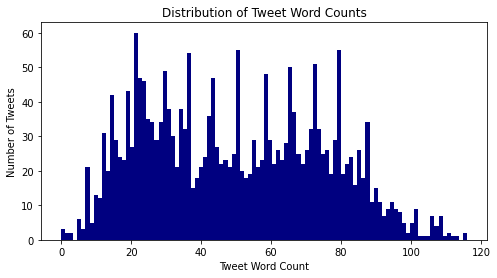

In [157]:
apple_text_length=[len(d) for d in tweet_apple_words];
# Plot
plt.figure(figsize=(8,4))
plt.hist(apple_text_length, bins = 100, color='navy')
print("Mean number of words per tweet   : ", (round(np.mean(apple_text_length))))
print("Median number of words per tweet : ", (round(np.median(apple_text_length))))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

In [158]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(apple_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                              

In [159]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(apple_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -3249.659401628509
Model Perplexity:  157.0304369748838


In [160]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(apple_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(tweet_apple_clean['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    1475
1     736
Name: dominant_topic, dtype: int64

In [161]:
# Topic-Keyword Matrix
df_topic_keywords_apple = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_apple.columns = cv.get_feature_names()
df_topic_keywords_apple.index = topicnames

# View
df_topic_keywords_apple.head()

,able,account,adair,adam,album,amazon,amazonin,android,anything,app,...,wish,without,word,work,working,world,worth,xikooba,year,yet
Topic0,5.126466,10.911530,0.871033,13.041078,4.273181,12.577188,0.827504,3.740868,6.918459,23.930214,...,16.964904,0.779624,9.470680,15.439089,0.900361,0.707972,9.386897,0.713963,2.675112,1.715506
Topic1,5.004846,1.491892,8.417374,1.140623,8.468265,0.798800,8.126772,17.116816,3.521358,18.267968,...,1.063364,7.941328,0.873712,2.258228,8.004314,8.098447,1.051256,10.270528,12.437271,7.181702


In [162]:
#Show top keywords
topic_keywords_apple = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_apple = pd.DataFrame(topic_keywords_apple)
df_topic_keywords_apple.columns = ['Word '+str(i) for i in range(df_topic_keywords_apple.shape[1])]
df_topic_keywords_apple.index = ['Topic '+str(i) for i in range(df_topic_keywords_apple.shape[0])]

# Manually assign topics
df_topic_keywords_apple['Topics']=['phone app', 'music streaming']
df_topic_keywords_apple

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,music,spotify,store,google,app,song,podcast,microsoft,available,eye,back,wish,link,pro,tidal,phone app
Topic 1,iphone,phone,new,people,product,big,best,song,app,android,help,buy,stream,realdonaldtrump,guy,music streaming


## Huawei topic modeling

In [163]:
tweet_huawei_clean=tweet_combined_clean[tweet_combined_clean['brand']==2]
tweet_huawei_words=tweet_huawei_clean['text'].apply(text_processer)
huawei_vectorized=cv.fit_transform(tweet_huawei_words)

Mean number of words per tweet   :  57.0
Median number of words per tweet :  62.0


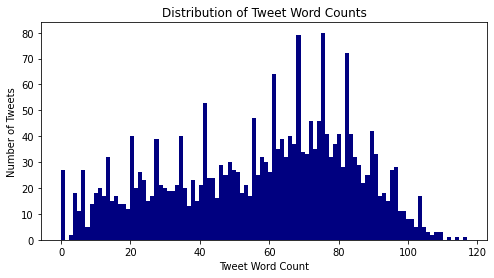

In [164]:
huawei_text_length=[len(d) for d in tweet_huawei_words];
# Plot
plt.figure(figsize=(8,4))
plt.hist(huawei_text_length, bins = 100, color='navy')
print("Mean number of words per tweet   : ", (round(np.mean(huawei_text_length))))
print("Median number of words per tweet : ", (round(np.median(huawei_text_length))))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

In [165]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(huawei_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                              

In [166]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(huawei_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -7305.12499617734
Model Perplexity:  236.6742562354973


In [167]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(huawei_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(tweet_huawei_clean['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    1533
1     871
Name: dominant_topic, dtype: int64

In [168]:
# Topic-Keyword Matrix
df_topic_keywords_huawei = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_huawei.columns = cv.get_feature_names()
df_topic_keywords_huawei.index = topicnames

# View
df_topic_keywords_huawei.head()

,accept,alghammer,amazing,america,american,amicuscelebrant,android,another,anyone,anything,...,western,wireless,work,working,world,wrong,xiaomi,year,yet,zoom
Topic0,9.359332,9.420200,7.208881,1.765534,4.617732,7.442782,0.877143,3.169382,18.043295,11.389814,...,3.855665,12.402901,21.243198,13.558050,44.311255,1.616216,12.834980,3.669200,1.185031,1.107089
Topic1,0.663772,0.838613,1.989785,20.156992,6.295317,2.494507,10.039514,6.743065,1.194088,10.524644,...,5.717159,1.606833,0.879990,0.766586,9.175159,12.176302,1.161667,26.032695,11.792961,17.852798


In [169]:
#Show top keywords
topic_keywords_huawei = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_huawei = pd.DataFrame(topic_keywords_huawei)
df_topic_keywords_huawei.columns = ['Word '+str(i) for i in range(df_topic_keywords_huawei.shape[1])]
df_topic_keywords_huawei.index = ['Topic '+str(i) for i in range(df_topic_keywords_huawei.shape[0])]

# Manually assign topics
df_topic_keywords_huawei['Topics']=['China communist party', 'China-US']
df_topic_keywords_huawei

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,china,chinese,canada,mask,company,globalnews,europe,pro,leeszla,world,communist,mike,government,sunlorrie,buy,China communist party
Topic 1,china,ccp,phone,people,country,virus,realdonaldtrump,technology,year,ttsampaio,device,america,tech,red,first,China-US


Despite its great results on medium or large sized texts (>50 words), typically mails and news articles are about this size range, LDA poorly performs on short texts like Tweets. The assumption that a text is a mixture of topics is not true anymore. We will now assume that a short text is made from only one topic.

## Topic modeling on negative samsung tweets

In [120]:
samsung_tweet_neg_words=samsung_tweet_neg['text'].apply(text_processer)
samsung_tweet_neg_vectorized=cv.fit_transform(samsung_tweet_neg_words)

In [128]:
len(samsung_tweet_neg_words)

394

In [121]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_tweet_neg_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                              

In [122]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_tweet_neg_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -124.26195401445341
Model Perplexity:  13.159379317174055


In [124]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(samsung_tweet_neg_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(samsung_tweet_neg['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    344
1     50
Name: dominant_topic, dtype: int64

In [126]:
# Topic-Keyword Matrix
df_topic_keywords_samsung_neg = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_samsung_neg.columns = cv.get_feature_names()
df_topic_keywords_samsung_neg.index = topicnames

# View
df_topic_keywords_samsung_neg.head()

,android,bad,buy,company,galaxy,iphone,oneplus,phone,problem,product,series
Topic0,5.041988,1.207178,1.328709,1.259437,13.367322,7.490961,1.287767,11.484292,6.566559,0.761515,1.430104
Topic1,1.491714,9.641013,3.602012,4.272512,1.477771,3.584046,10.677234,2.647884,1.076500,3.840684,3.402030


In [127]:
#Show top keywords
topic_keywords_samsung_neg = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_samsung_neg = pd.DataFrame(topic_keywords_samsung_neg)
df_topic_keywords_samsung_neg.columns = ['Word '+str(i) for i in range(df_topic_keywords_samsung_neg.shape[1])]
df_topic_keywords_samsung_neg.index = ['Topic '+str(i) for i in range(df_topic_keywords_samsung_neg.shape[0])]

# Manually assign topics
#df_topic_keywords_samsung_neg['Topics']=['China communist party', 'China-US']
df_topic_keywords_samsung_neg

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,galaxy,phone,iphone,problem,android,series,buy,oneplus,company,bad,product
Topic 1,oneplus,bad,company,product,buy,iphone,series,phone,android,galaxy,problem


## Topic modeling on positive samsung tweets

In [129]:
samsung_tweet_pos_words=samsung_tweet_pos['text'].apply(text_processer)
samsung_tweet_pos_vectorized=cv.fit_transform(samsung_tweet_pos_words)

In [130]:
len(samsung_tweet_pos_words)

965

In [131]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_tweet_pos_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_tweet_pos_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -1099.888524623874
Model Perplexity:  58.92629617422572


In [136]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(samsung_tweet_pos_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(samsung_tweet_pos['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    682
1    283
Name: dominant_topic, dtype: int64

In [137]:
# Topic-Keyword Matrix
df_topic_keywords_samsung_pos = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_samsung_pos.columns = cv.get_feature_names()
df_topic_keywords_samsung_pos.index = topicnames

# View
df_topic_keywords_samsung_pos.head()

,android,app,best,bought,buy,camera,channel,device,fan,free,...,super,support,tablet,teejaye,tell,though,ultra,user,work,year
Topic0,17.733616,11.690529,8.926025,5.857205,11.175972,13.071953,0.900768,7.535584,7.223285,0.951122,...,2.207602,6.017030,6.538425,5.644857,5.620523,2.288227,1.438224,12.094725,11.373392,12.074274
Topic1,1.700982,7.400408,6.247578,1.616798,1.963529,1.710648,17.631742,1.479736,2.326615,9.698232,...,5.254587,1.374279,2.038070,1.290769,2.356971,5.263529,7.832247,1.412894,1.503271,2.621958


In [139]:
#Show top keywords
topic_keywords_samsung_pos = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_samsung_pos = pd.DataFrame(topic_keywords_samsung_pos)
df_topic_keywords_samsung_pos.columns = ['Word '+str(i) for i in range(df_topic_keywords_samsung_pos.shape[1])]
df_topic_keywords_samsung_pos.index = ['Topic '+str(i) for i in range(df_topic_keywords_samsung_pos.shape[0])]

# Manually assign topics
#df_topic_keywords_samsung_neg['Topics']=['China communist party', 'China-US']
df_topic_keywords_samsung_pos

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,phone,iphone,note,android,oneplus,pretty,camera,screen,user,year,app,work,samsungmobileus,buy,price
Topic 1,galaxy,smart,play,channel,new,pakistani,help,free,lite,ultra,going,plz,pakistan,guy,app
